Regression for predicting the price of the house

# Steps we will follow:

## 1. Define the objective
- defining the target 
- defining a acceptable error (we will take into account MAE for the error) → **So define Maximum MAE**

---

## 2. Select data for the model
- cleaning of that data (en principio no va a hacer falta)
- Detectar outliers que puedan romper el modelo

---

## 3. EDA para detectar si un linear regression va a ser suficiente: justificarlo y aplicar un linear regression para demostrarlo

### 3.1 Univariado
- Distribución del target.
- Distribución y estadísticas de las features.

### 3.2 Bivariado
- Correlaciones numéricas (heatmap).
- ANOVA / boxplots para categóricas vs target.

### 3.3 Detectar no linealidades
- Scatterplots X vs Y.
- Transformaciones (log, sqrt) si una relación no es lineal.
- Crear polinómicas si es necesario.

> 👉 Aquí decides si la regresión lineal tiene sentido o necesitas algo más poderoso.

---

### ✔️ ¿Cómo elegir definitivamente?
Se hace así:

1️⃣ Divide los datos (train/test)  
2️⃣ Ejecuta cross-validation con GridSearch:  

- Lasso  
- Ridge  
- ElasticNet  

El que dé mejor MAE o RMSE → ese gana.  

➡️ No se decide a ojo. Se decide con CV.

---

## 4. Validar Supuestos: (aplicar lasso directamente y verificar)
- Linealidad
- Independencia de residuos

---

## 5. Preprocesing
- Dividir train y test
- Scaled, categorical-variables...

---

## 6. Entrenar y probar con varios modelos (usando cross validation)

### Entrenar y probar con:
- ✔️ RANSAC  
  Para outliers, recomendado

- ✔️ Theil-Sen  
  Robusto a ruido, muy usado en datos inestables

- ✔️ HuberRegressor  
  Mezcla LR con robustez

- ✔️ RandomForestRegressor  
  No lineal, buen baseline potente

- ✔️ CatBoost  
  De lo mejor en tabular  
  No requiere escalado  
  Maneja categóricas

- ✔️ XGBoost

- ✔️ LightGBM  

Casi siempre da un rendimiento brutal

---

### Evaluar métricas
- R², MAE
- Comprobar si hay overfitting o underfitting en cada modelo:  
    - Overfitting → test mucho peor que train  
    - Underfitting → ambos malos  
    - Buen modelo → train ≈ test y métricas buenas  

> 👉 El test manda; si test es bueno → el modelo generaliza.

---

## 7. Diagnóstico final (para verificar si el modelo que hemos elegido esta bien)
- Residuals vs predicted
- Predicted vs actual
- Q-Q plot
- Importancia de variables
- Coeficientes interpretables (si es lineal)














### IMPORTS

In [78]:
import pandas as pd
import numpy as np
import statistics as st

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack


### LOAD DATA

In [79]:
#load the data

data = pd.read_csv('../data/cleaned/data_final.csv')
dataCpy = data.copy()

### 1: Define the objective of the regression: 
- Objective: our regression model will predict ("tell") the announcement price of your house with the house data as input. 
- Target feature: price
- Now we will justify which will, what we will consider an acceptable maximum MAE

In [80]:
#Since the target feature is the price, the MAE will be in € units.

#AN OPTION WOULD BE: 

#1.We will get which is the standard deviation of "price" feature 
std_price = dataCpy["price"].std()
print(f"Standard deviation of the feature 'price': {round(std_price,2)}€") #--> The values of "price" differ from the mean: 310649.51€

#2.The maximum accepatble MAE could be a percentage of that standard deviation value. 
#In the house business, 31.000€ more or less expensive may have an impact on buyers, however a price of 10.000€ may not have so much impact. 
#So an acceptale MAE will be 10.000€ for all the predictions. 





Standard deviation of the feature 'price': 310775.75€


HOWEVER: 

The first option would be easier to implement (1 fixed maximum MAE for all the predictions). However, this would not be true. 
Since 10.000€ may not have an impact (would be an acecptable MAE) for a house of 500.000€ for example, but would have a big 
impact (would NOT be an acceptable MAE) for a house of 50.000€.

So we will take into account the "relative MAE" with an error of 5%. So for example: 

In [81]:

print(f"Cheapest House: {round(min(dataCpy["price"]),2)}€")
print(f"5% = {round(min(dataCpy["price"])*0.05,2)}€\n")

print(f"Most Expensive House: {round(max(dataCpy["price"]),2)}€")
print(f"5% = {round(max(dataCpy["price"])*0.05,2)}€\n")

print(f"Average price House: {round(st.mean(dataCpy["price"]),2)}€")
print(f"5% = {round(st.mean(dataCpy["price"])*0.05,2)}€\n")


Cheapest House: 50000.0€
5% = 2500.0€

Most Expensive House: 2500000.0€
5% = 125000.0€

Average price House: 476994.44€
5% = 23849.72€



### 2: Data cleaning for the model

In [82]:
#1.We will check if there are missing values (there should not be any, since we have previously done data cleaning)
print(f"Missing values:\n{dataCpy.isnull().sum()}") #0 missing values in target PERFECT
                                                    #8 MISSING VALUES IN DESCRIPTION!!

#we will fill those missing values with empty string ""

dataCpy.loc[dataCpy["description"].isnull(), "description"] = ""





Missing values:
url                  0
price                0
zone                 0
neighborhood         0
built_area           0
usable_area          0
bedrooms             0
bathrooms            0
floor                0
exterior             0
elevator             0
garage               0
storage_room         0
balcony              0
new                  0
condition            0
year                 0
agency               0
consumption_label    0
emissions_label      0
description          8
dtype: int64


In [83]:
print(f"Missing values:\n{dataCpy.isnull().sum()}") #now there are not missing values


Missing values:
url                  0
price                0
zone                 0
neighborhood         0
built_area           0
usable_area          0
bedrooms             0
bathrooms            0
floor                0
exterior             0
elevator             0
garage               0
storage_room         0
balcony              0
new                  0
condition            0
year                 0
agency               0
consumption_label    0
emissions_label      0
description          0
dtype: int64


In [84]:
#2.We will check if there are any outliers in the values of "price"

#2.1 First we will see if there are univariate outliers in the feature price
Q1 = dataCpy['price'].quantile(0.25)
Q3 = dataCpy['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = dataCpy[(dataCpy['price'] < Q1 - 1.5*IQR) | (dataCpy['price'] > Q3 + 1.5*IQR)]

print(f"Univariate Outliers: {outliers.head()}") #Here we get some houses with a very expensive price, however they are not really outliers (nor strange values), they are just expensive houses which we must also take into account.

#2.2 Second we will see if there are multivariate outliers

iso = IsolationForest(contamination=0.01, random_state=42)
numerical_features = dataCpy.select_dtypes(include=np.number)
outliers_IF = iso.fit_predict(numerical_features)

# Filtrar solo los outliers
outliers_IF_df = dataCpy[outliers_IF == -1]

print("Isolation Forest - solo outliers:")
print(outliers_IF_df)


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
outliers_LOF = lof.fit_predict(numerical_features)

# Filtrar solo los outliers
outliers_LOF_df = dataCpy[outliers_LOF == -1]

print("LOF - solo outliers:")
print(outliers_LOF_df)

#As we can see these are not outliers (there are not strange values), they are just expensive or houses with different features. We will maintain them.



Univariate Outliers:                                                url      price      zone  \
78   https://www.idealista.com/inmueble/108492917/  1400000.0    deusto   
114  https://www.idealista.com/inmueble/105222282/  2500000.0  uribarri   
137  https://www.idealista.com/inmueble/108035998/  1180000.0  uribarri   
148  https://www.idealista.com/inmueble/108037499/  1190000.0  uribarri   
185   https://www.idealista.com/inmueble/32760790/  1400000.0  uribarri   

                        neighborhood  built_area  usable_area  bedrooms  \
78                 Arangoiti, Bilbao       351.0        350.0         4   
114  Campo Volantin-Castaños, Bilbao       426.0        384.0         8   
137  Campo Volantin-Castaños, Bilbao       114.0         95.0         3   
148  Campo Volantin-Castaños, Bilbao       250.0        230.0         4   
185                 Uribarri, Bilbao       426.0        350.0         8   

     bathrooms  floor  exterior  ...  garage  storage_room  balcony    new  \

In [85]:
#3.We will get the features which the model will be working with (initally)
print(f"All features: {dataCpy.columns}\n\n")

#target
target_price = dataCpy.price

#For training the model will not take into account: Url, price (is the target) and description.
data_regresion = dataCpy.drop(["url","price", "description"], axis=1)
print(f"Initially selected features: {data_regresion.columns}")


#We deleted description feature, since the goal of the model is to predict or tell and announcment price with objective data of your house.


All features: Index(['url', 'price', 'zone', 'neighborhood', 'built_area', 'usable_area',
       'bedrooms', 'bathrooms', 'floor', 'exterior', 'elevator', 'garage',
       'storage_room', 'balcony', 'new', 'condition', 'year', 'agency',
       'consumption_label', 'emissions_label', 'description'],
      dtype='object')


Initially selected features: Index(['zone', 'neighborhood', 'built_area', 'usable_area', 'bedrooms',
       'bathrooms', 'floor', 'exterior', 'elevator', 'garage', 'storage_room',
       'balcony', 'new', 'condition', 'year', 'agency', 'consumption_label',
       'emissions_label'],
      dtype='object')


### 3.EDA 
- To evaluate if a linear regression model can accurately capture the relationship between the features and the target, before training any model.

UNIVARIATE------------------------------------
Target - Estadísticas generales:
count    1.229000e+03
mean     4.769944e+05
std      3.107758e+05
min      5.000000e+04
25%      2.650000e+05
50%      3.950000e+05
75%      5.990000e+05
max      2.500000e+06
Name: price, dtype: float64

Skew: 2.109654537879016
Kurtosis: 6.894991473049991


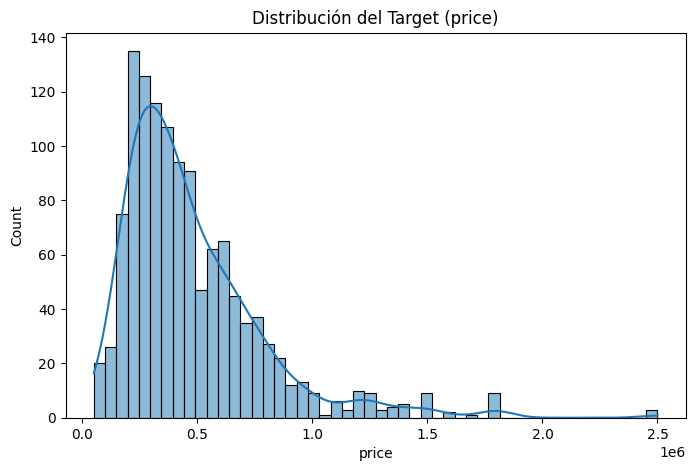


Feature: built_area
count    1229.000000
mean      114.688365
std        66.047508
min        30.000000
25%        72.000000
50%        98.000000
75%       134.000000
max       760.000000
Name: built_area, dtype: float64


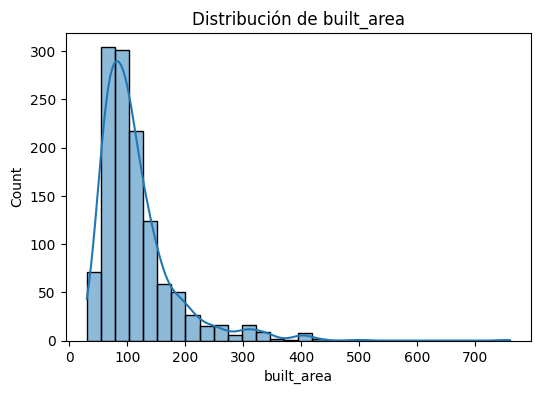


Feature: usable_area
count    1229.000000
mean      102.855134
std        60.286864
min        26.336611
25%        65.000000
50%        85.000000
75%       120.000000
max       706.012840
Name: usable_area, dtype: float64


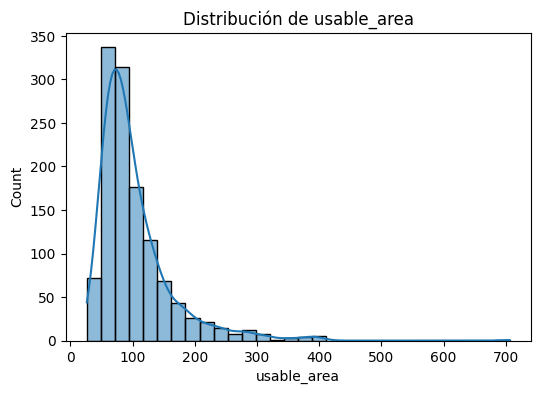


Feature: bedrooms
count    1229.000000
mean        3.068348
std         1.434867
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        14.000000
Name: bedrooms, dtype: float64


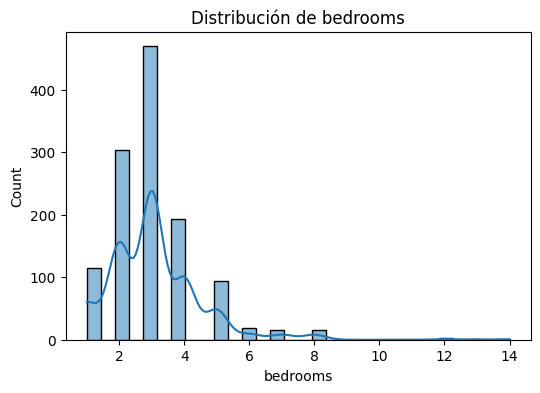


Feature: bathrooms
count    1229.000000
mean        1.768104
std         0.785096
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: bathrooms, dtype: float64


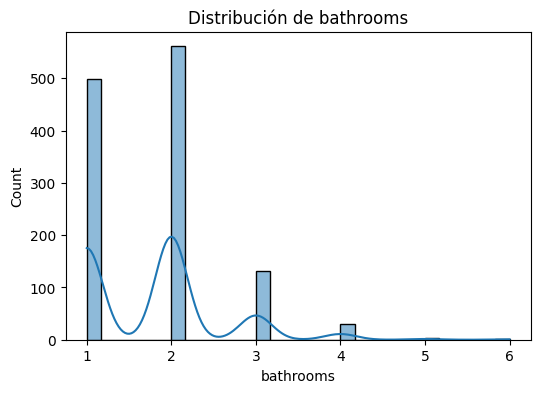


Feature: floor
count    1229.000000
mean        3.696908
std         3.102530
min        -1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        35.000000
Name: floor, dtype: float64


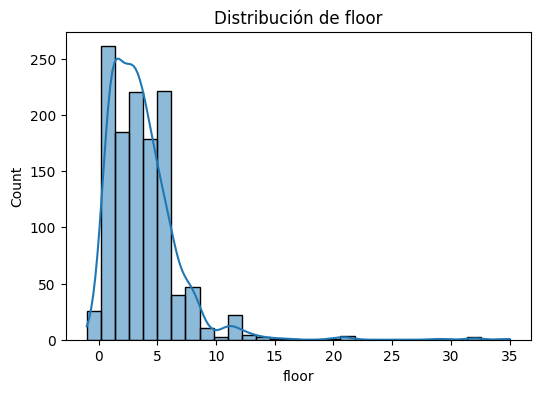


Feature: year
count    1229.000000
mean     1961.676159
std        37.060905
min      1800.000000
25%      1941.000000
50%      1963.000000
75%      1980.000000
max      2025.000000
Name: year, dtype: float64


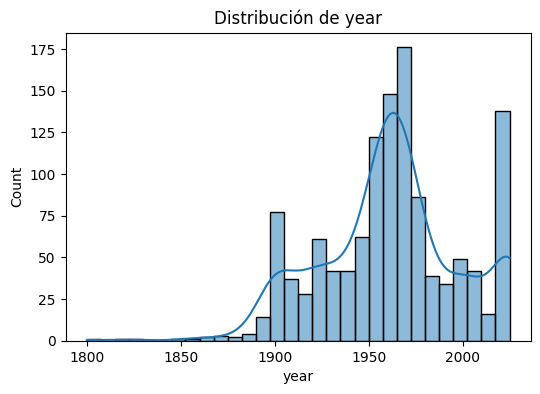

BIVARIATE------------------------------------


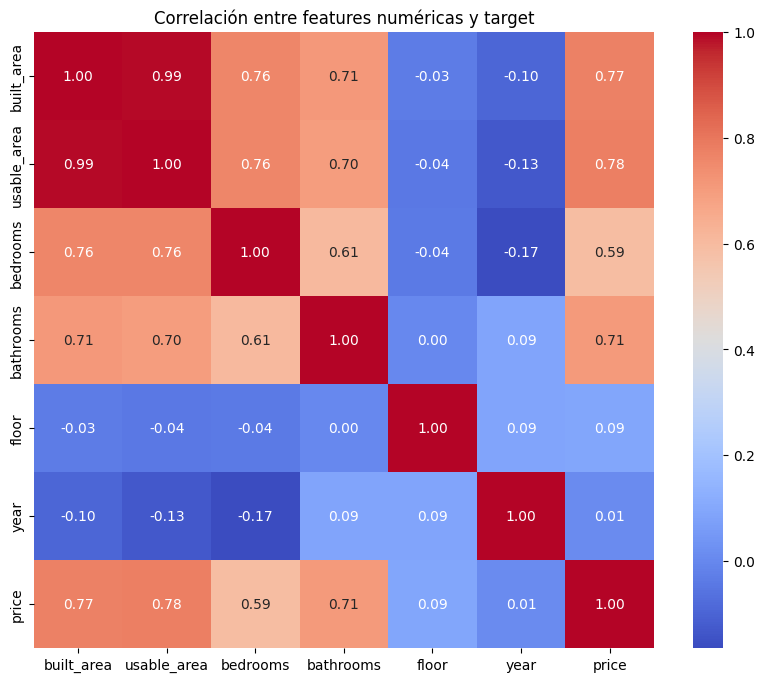

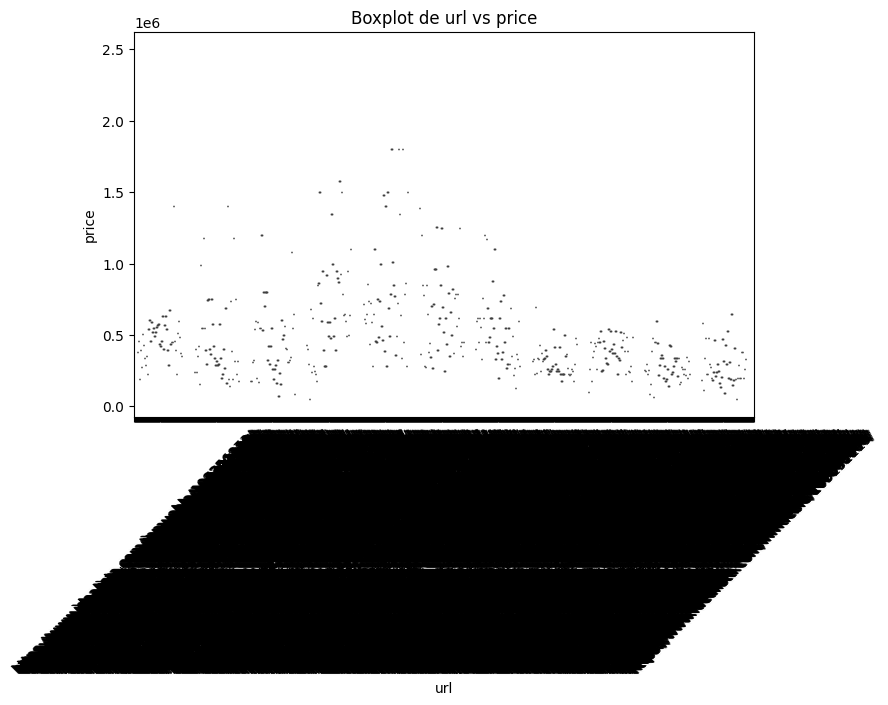

ANOVA url vs price: F=nan, p=nan


C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\david.r\AppData\Local\Temp\ipykernel_28904\3627693939.py:66: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_val, p_val = stats.f_oneway(*groups)


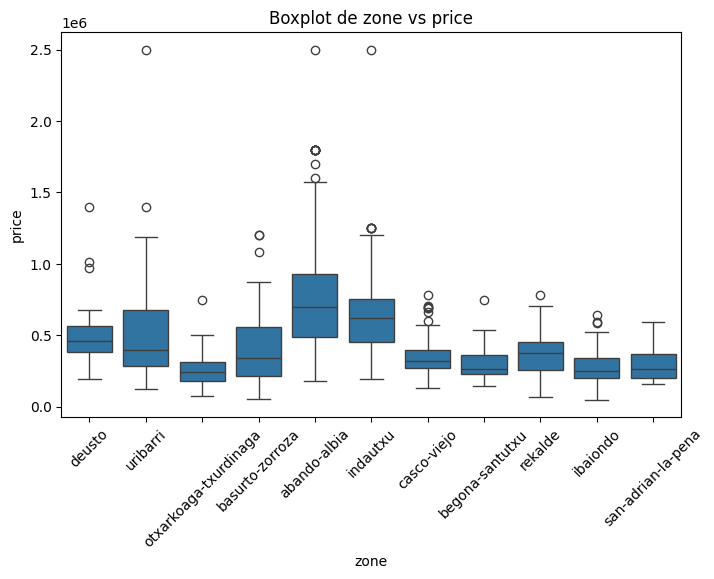

ANOVA zone vs price: F=62.03, p=0.0000


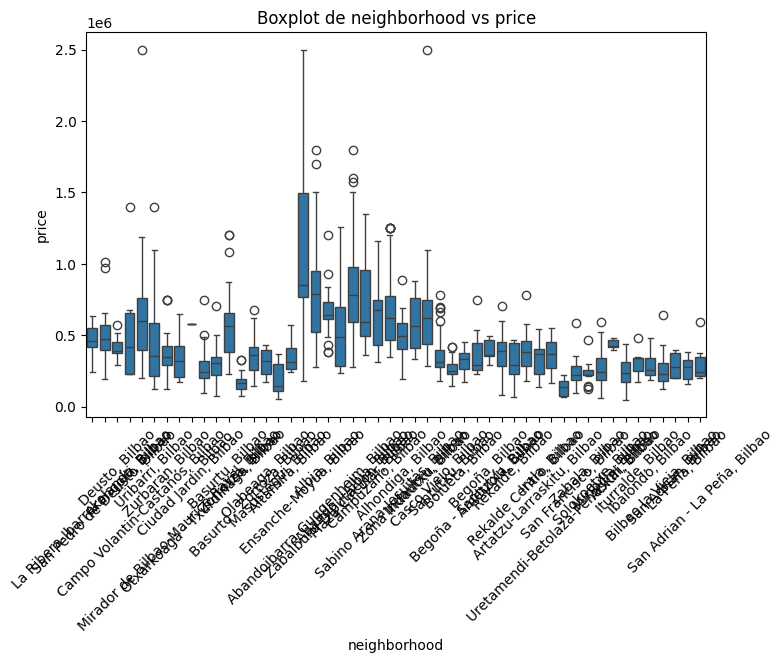

ANOVA neighborhood vs price: F=20.23, p=0.0000


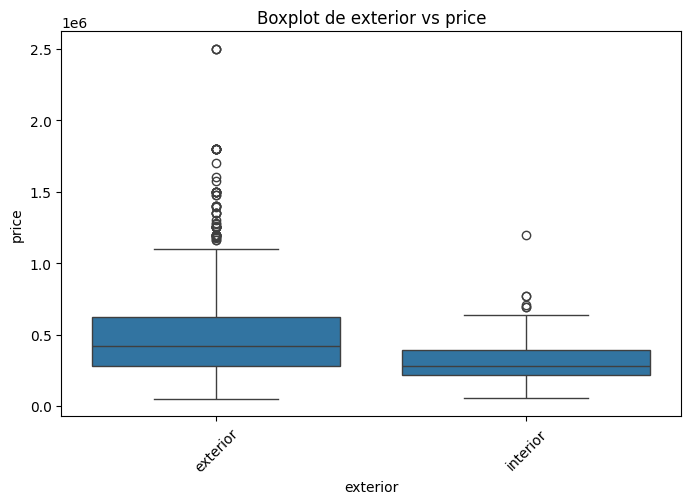

ANOVA exterior vs price: F=48.62, p=0.0000


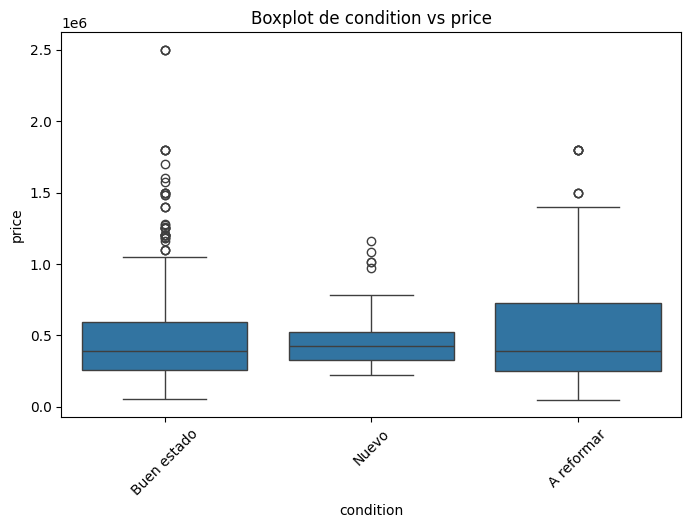

ANOVA condition vs price: F=3.40, p=0.0336


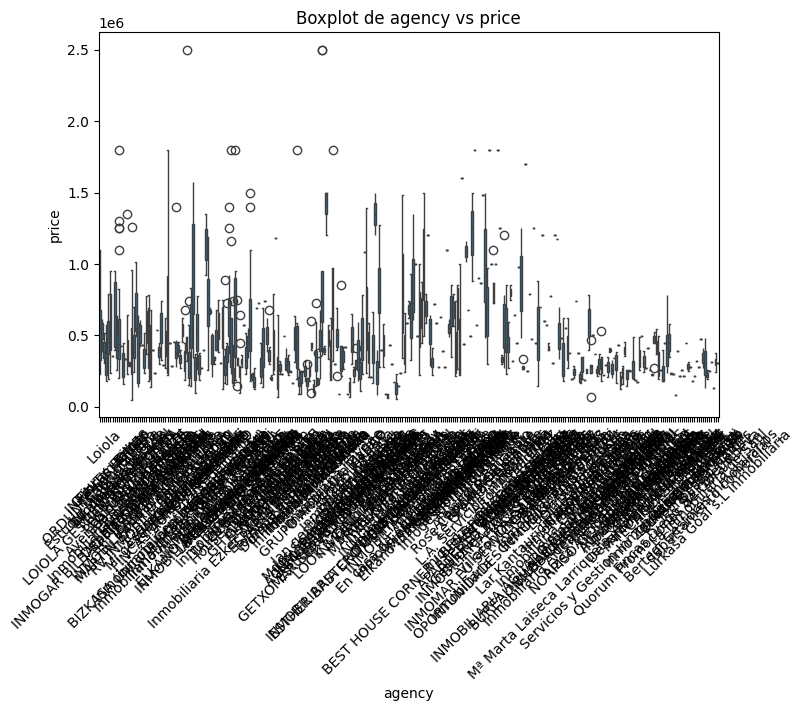

ANOVA agency vs price: F=3.05, p=0.0000


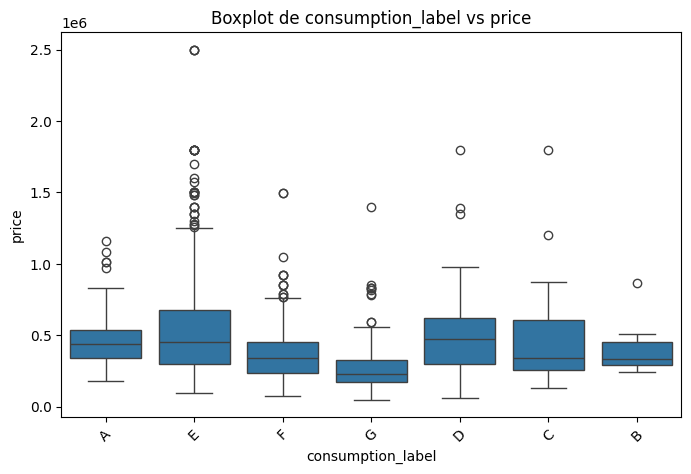

ANOVA consumption_label vs price: F=22.76, p=0.0000


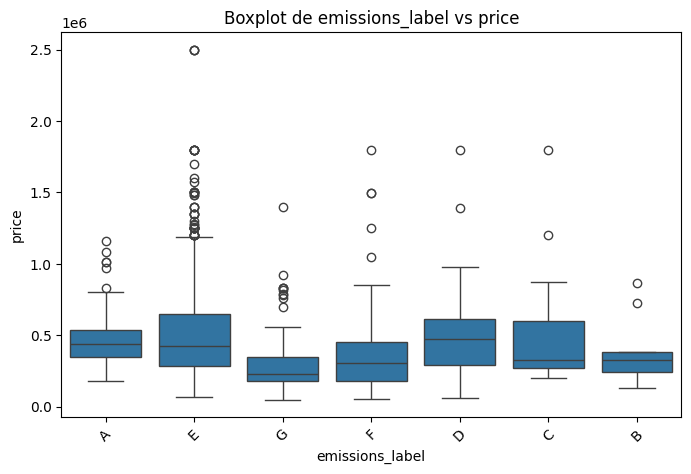

ANOVA emissions_label vs price: F=10.91, p=0.0000
DETECT NON LINEARITY------------------------------------


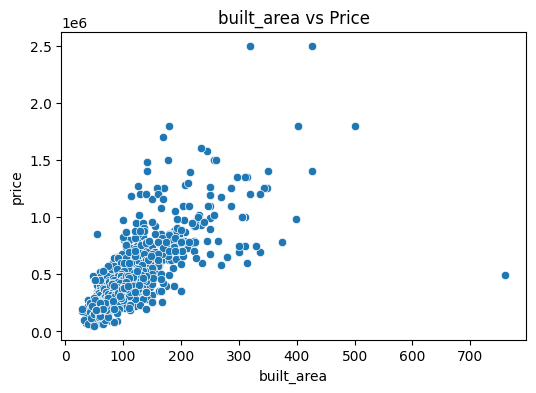

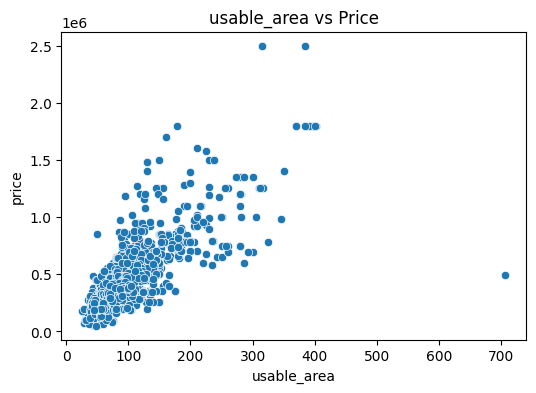

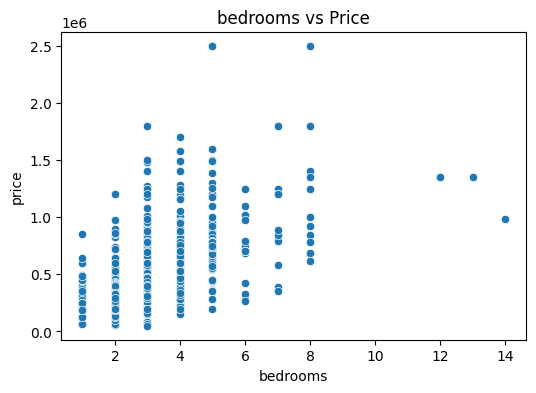

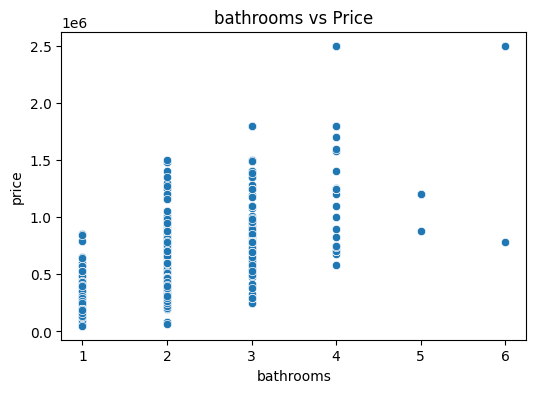

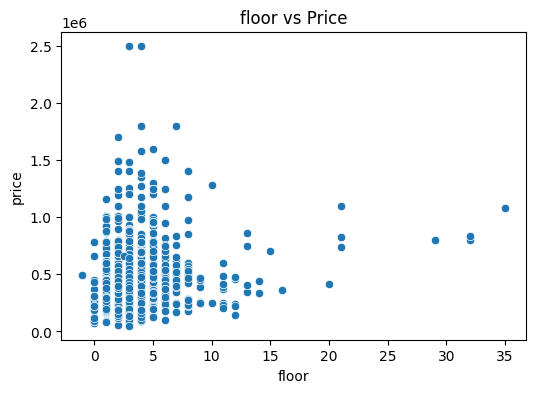

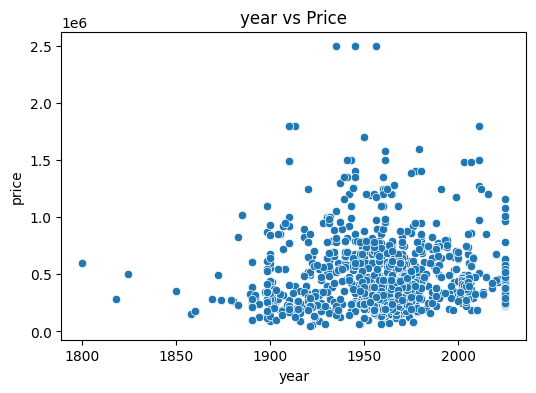

'\n# Crear polinómicas si la relación parece curva (ejemplo 2do grado)\n\nfrom sklearn.preprocessing import PolynomialFeatures\n\npoly = PolynomialFeatures(degree=2, include_bias=False)\nX_poly_example = poly.fit_transform(dataCpy[[\'built_area\']])  # ejemplo\nprint("Columnas generadas por polinómica:", poly.get_feature_names_out([\'built_area\']))\n'

In [86]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Suponiendo que tu dataframe se llama dataCpy
# y la variable objetivo es 'price'

# -------------------------------
# 3.1 Univariado
# -------------------------------
print("UNIVARIATE------------------------------------")
# Estadísticas generales del target
print("Target - Estadísticas generales:")
print(dataCpy['price'].describe())
print("\nSkew:", dataCpy['price'].skew())
print("Kurtosis:", dataCpy['price'].kurtosis())

# Histograma del target
plt.figure(figsize=(8,5))
sns.histplot(dataCpy['price'], bins=50, kde=True)
plt.title("Distribución del Target (price)")
plt.show()

# Estadísticas y histogramas de features numéricas
numerical_features = dataCpy.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('price')  # excluimos el target

for col in numerical_features:
    print(f"\nFeature: {col}")
    print(dataCpy[col].describe())
    plt.figure(figsize=(6,4))
    sns.histplot(dataCpy[col], bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

# -------------------------------
# 3.2 Bivariado
# -------------------------------
print("BIVARIATE------------------------------------")

# Correlación numérica entre features y target
corr = dataCpy[numerical_features + ['price']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre features numéricas y target")
plt.show()

# Boxplots / ANOVA para categóricas
categorical_features = dataCpy.select_dtypes(include='object').columns.tolist()
if 'description' in categorical_features:
    categorical_features.remove('description')  # no usar la descripción de momento

for col in categorical_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=col, y='price', data=dataCpy)
    plt.title(f"Boxplot de {col} vs price")
    plt.xticks(rotation=45)
    plt.show()

    # ANOVA (opcional)
    categories = dataCpy[col].dropna().unique()
    groups = [dataCpy[dataCpy[col]==cat]['price'] for cat in categories]
    f_val, p_val = stats.f_oneway(*groups)
    print(f"ANOVA {col} vs price: F={f_val:.2f}, p={p_val:.4f}")

# -------------------------------
# 3.3 Detectar no linealidades
# -------------------------------
print("DETECT NON LINEARITY------------------------------------")

# Scatterplots de X vs Y (numéricas)
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='price', data=dataCpy)
    plt.title(f"{col} vs Price")
    plt.show()


"""
# Crear polinómicas si la relación parece curva (ejemplo 2do grado)

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_example = poly.fit_transform(dataCpy[['built_area']])  # ejemplo
print("Columnas generadas por polinómica:", poly.get_feature_names_out(['built_area']))
"""


As we can see in these results, the distribution of the target (price) is very skewed, which may be the reason of non linearity (or not clear linearity) with features like: floor or year.
So we will apply a logarithmic transformation to the target feature price. This should: 
- Improve futre heterodasdicity
- Improve current possible outliers 
- Improve linearity between features 

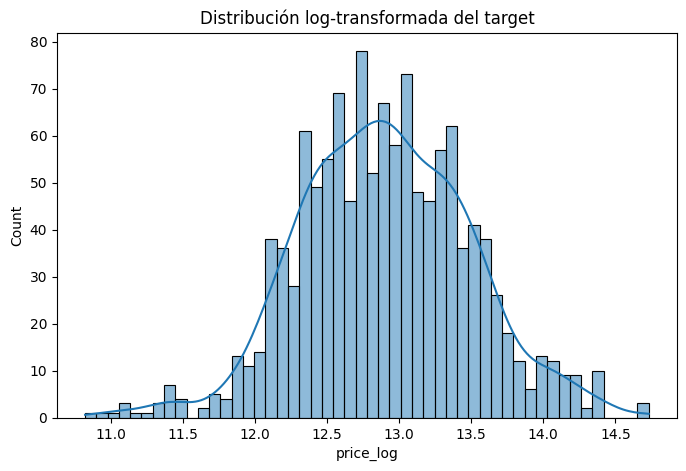


Skew: -0.0021085746449260837
Kurtosis: 0.29523924736662055
BIVARIATE------------------------------------


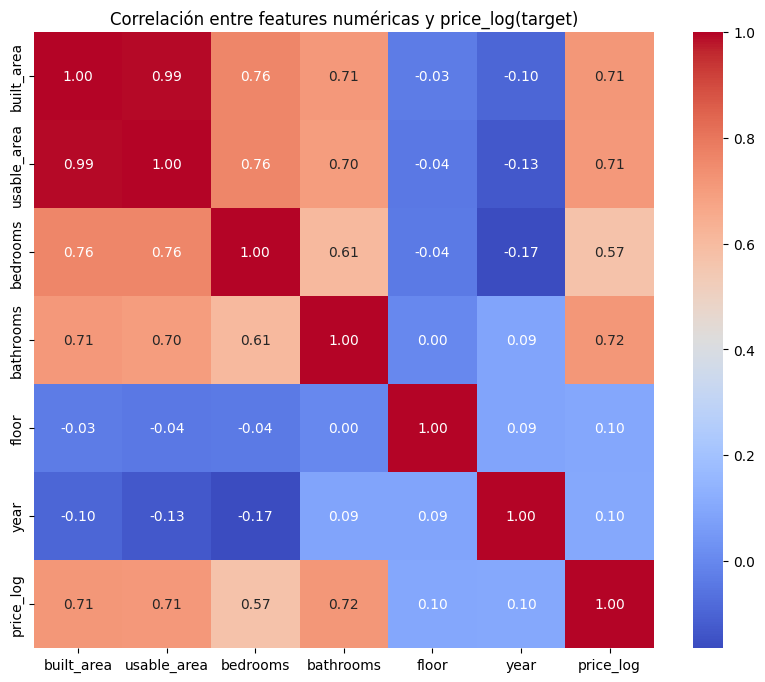

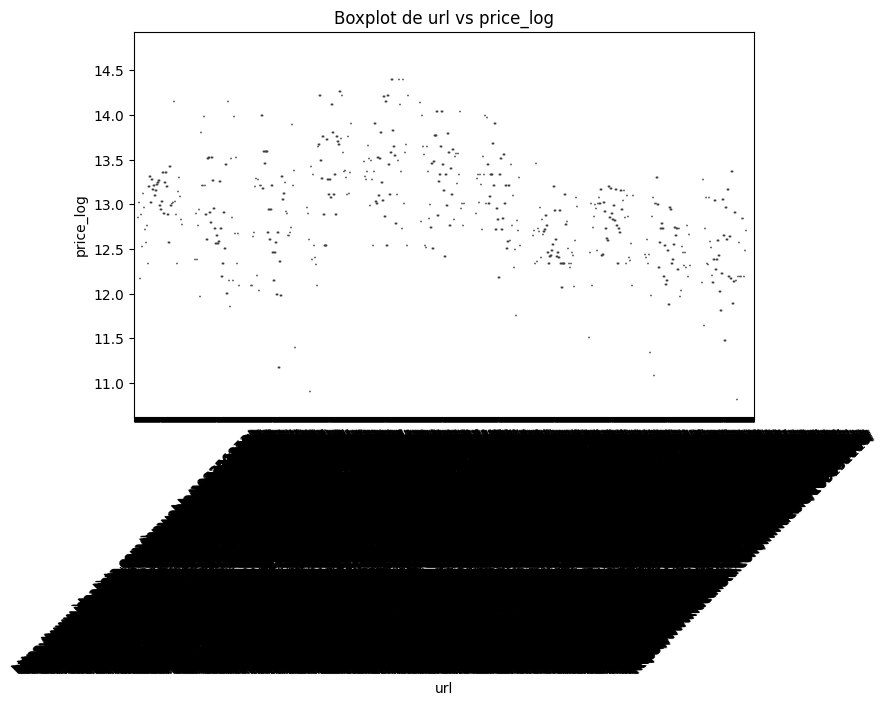

ANOVA url vs price_log: F=nan, p=nan


C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\david.r\AppData\Local\Temp\ipykernel_28904\2496092320.py:37: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_val, p_val = stats.f_oneway(*groups)


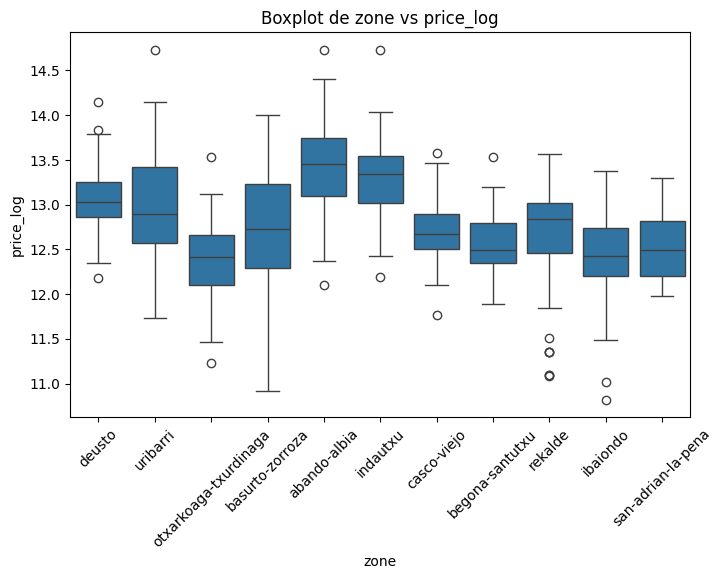

ANOVA zone vs price_log: F=69.90, p=0.0000


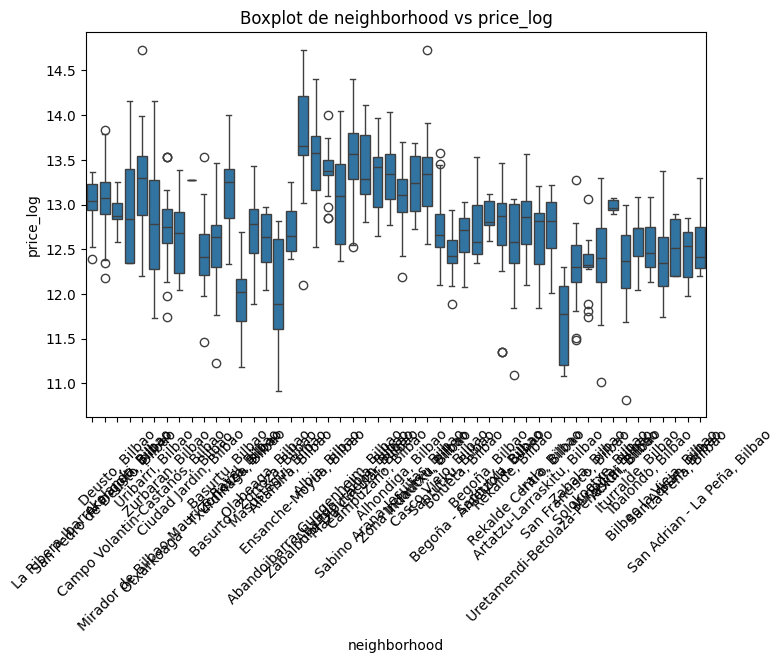

ANOVA neighborhood vs price_log: F=25.86, p=0.0000


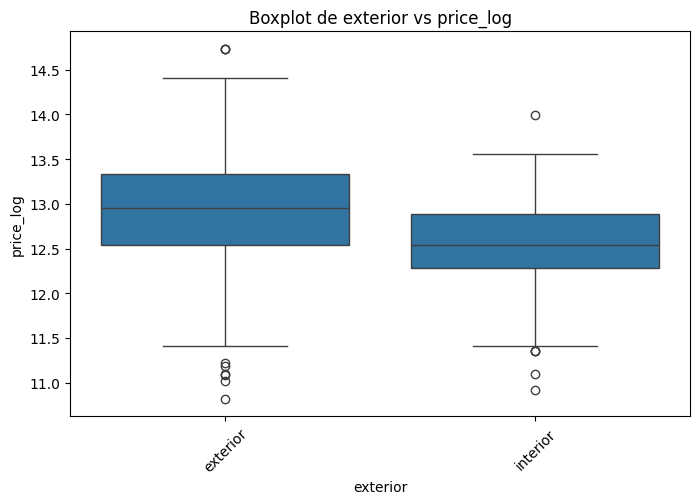

ANOVA exterior vs price_log: F=70.22, p=0.0000


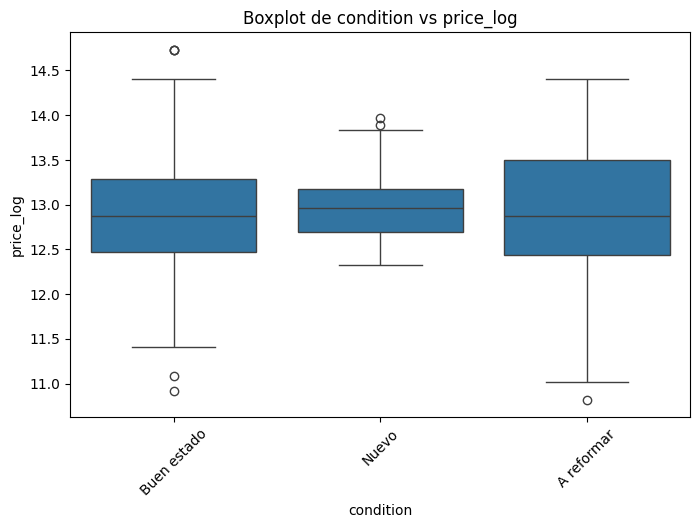

ANOVA condition vs price_log: F=0.92, p=0.3978


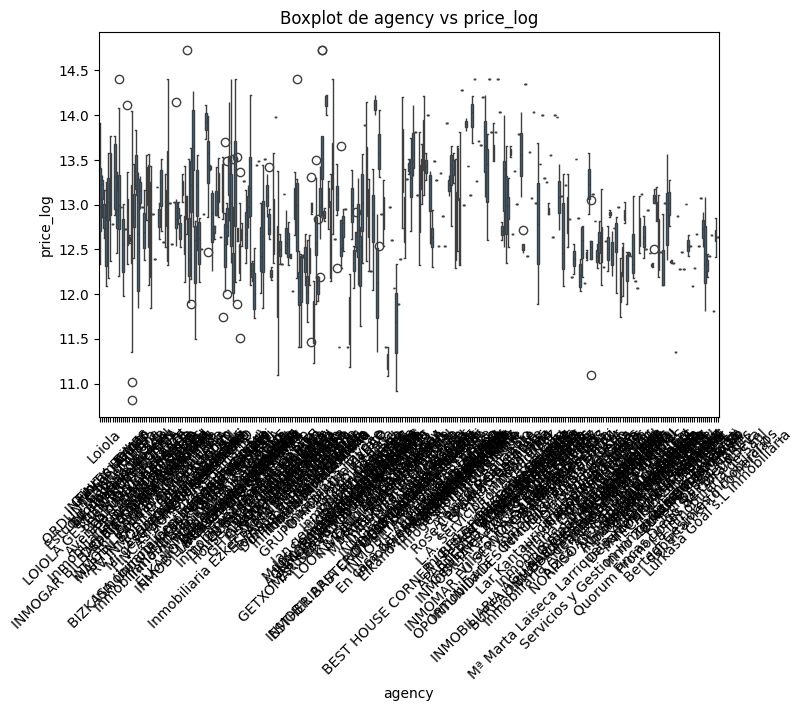

ANOVA agency vs price_log: F=3.24, p=0.0000


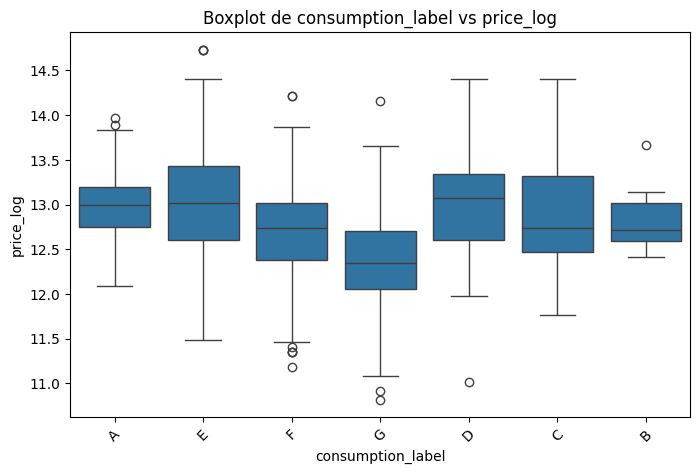

ANOVA consumption_label vs price_log: F=42.63, p=0.0000


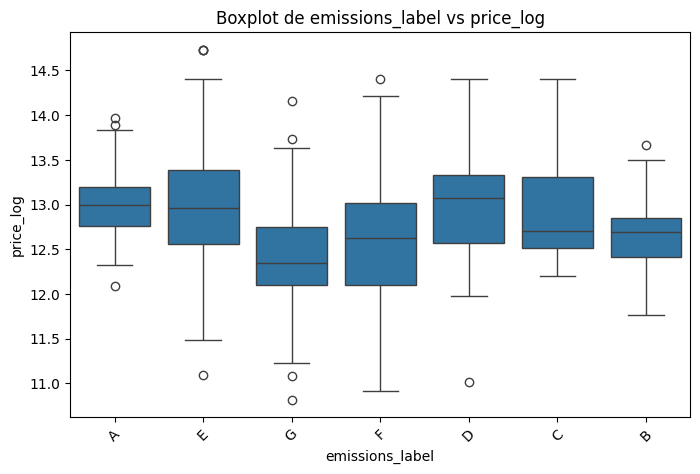

ANOVA emissions_label vs price_log: F=22.77, p=0.0000
DETECT NON LINEARITY------------------------------------


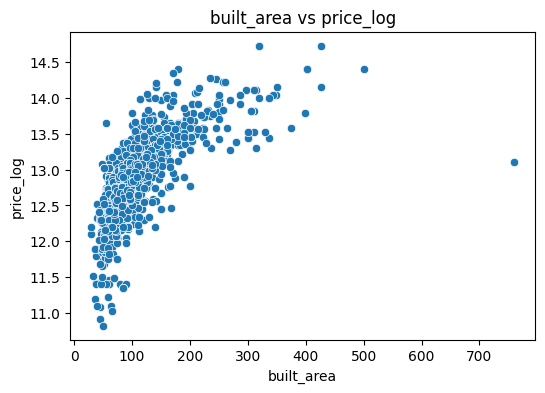

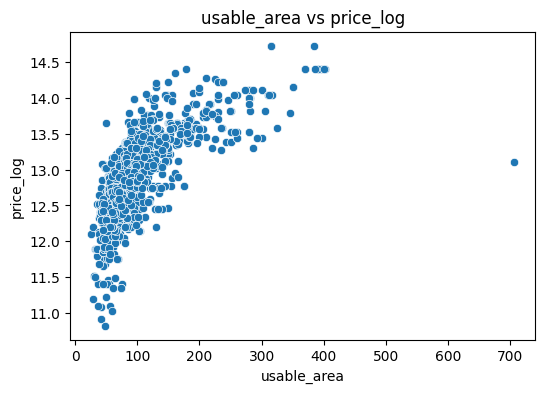

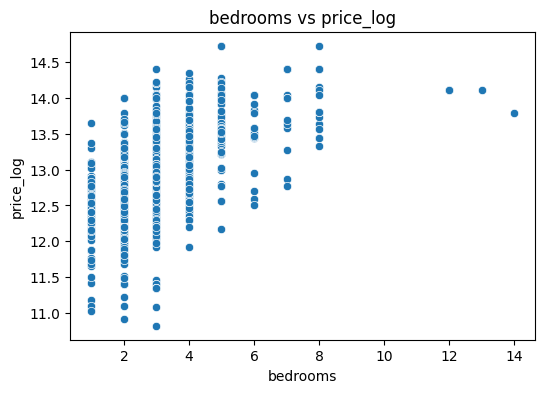

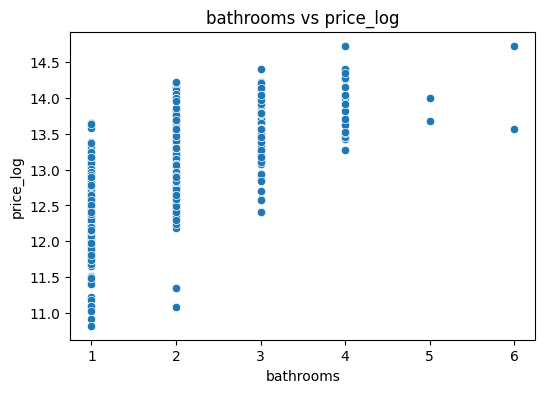

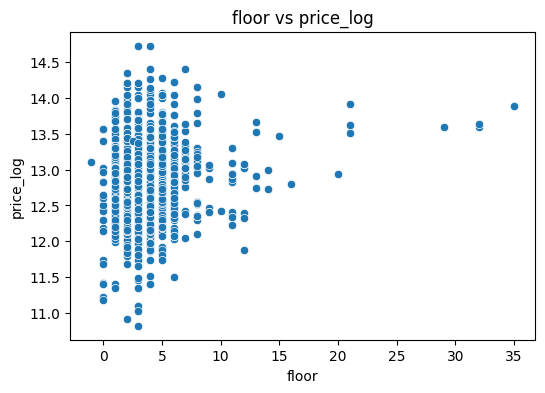

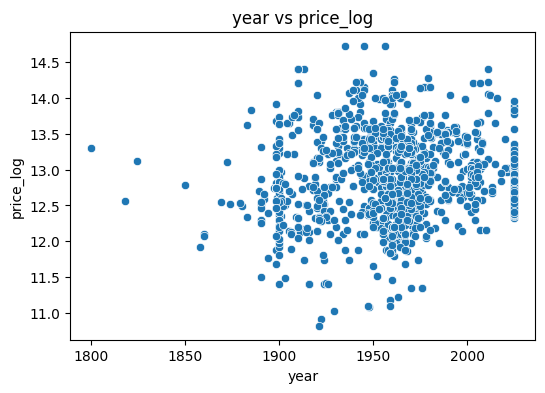

In [88]:

dataCpy['price_log'] = np.log1p(dataCpy['price'])
plt.figure(figsize=(8,5))
sns.histplot(dataCpy['price_log'], bins=50, kde=True)
plt.title("Distribución log-transformada del target")
plt.show()
print("\nSkew:", dataCpy['price_log'].skew())
print("Kurtosis:", dataCpy['price_log'].kurtosis())



# -------------------------------
# 3.2 Bivariate
# -------------------------------
print("BIVARIATE------------------------------------")

corr = dataCpy[numerical_features + ['price_log']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre features numéricas y price_log(target)")
plt.show()

# Boxplots / ANOVA para categóricas
categorical_features = dataCpy.select_dtypes(include='object').columns.tolist()
if 'description' in categorical_features:
    categorical_features.remove('description')  # no usar la descripción de momento

for col in categorical_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=col, y='price_log', data=dataCpy)
    plt.title(f"Boxplot de {col} vs price_log")
    plt.xticks(rotation=45)
    plt.show()

    # ANOVA (opcional)
    categories = dataCpy[col].dropna().unique()
    groups = [dataCpy[dataCpy[col]==cat]['price_log'] for cat in categories]
    f_val, p_val = stats.f_oneway(*groups)
    print(f"ANOVA {col} vs price_log: F={f_val:.2f}, p={p_val:.4f}")

print("DETECT NON LINEARITY------------------------------------")

# Scatterplots de X vs Y (numéricas)
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='price_log', data=dataCpy)
    plt.title(f"{col} vs price_log")
    plt.show()



The results have improved: 
- less potential outliers: previously in the boxplots of zone vs price, there were potential outliers in uribarri, abando and indautxu. In year vs price around 1950 there were also 3 possible outliers.
- We gained a little bit of linearity in floor vs price relation. 
- There is still not linearity between year and price, this means that "year" is not directly proportionl with price.

However we lost a little bit of linearity (now has kind of logaritmic shape) in usable_area vs price and in built_area vs price, so we will also transform usable_area and built_area to get that previous linearity. 

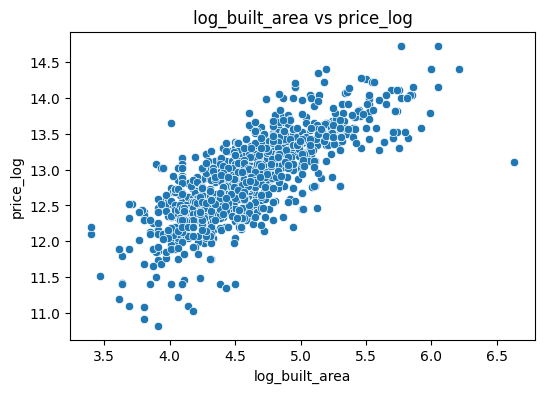

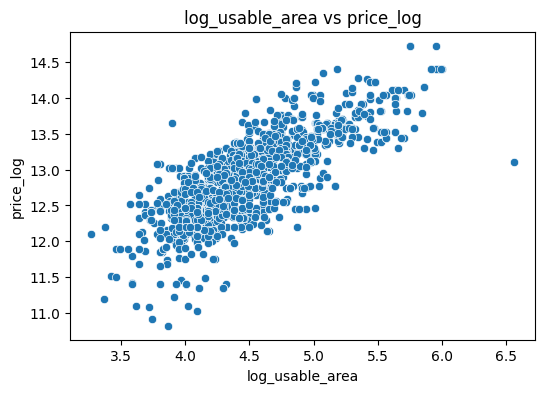

In [ ]:
dataCpy["log_built_area"] = np.log(dataCpy["built_area"])
dataCpy["log_usable_area"] = np.log(dataCpy["usable_area"])

for col in ["log_built_area","log_usable_area"]:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='price_log', data=dataCpy)
    plt.title(f"{col} vs price_log")
    plt.show()

#We have get that linearity again, PERFECT

We will check the 3 potential outliers (we will realize that they are 4) in bedroom vs price

In [ ]:
print(dataCpy.loc[dataCpy["bedrooms"]>=10])
#There are not strange things, so we will not remove them. 

                                               url      price          zone  \
391  https://www.idealista.com/inmueble/107849920/  1350000.0  abando-albia   
489  https://www.idealista.com/inmueble/107100389/  1350000.0  abando-albia   
526  https://www.idealista.com/inmueble/104320258/  1350000.0  abando-albia   
586  https://www.idealista.com/inmueble/107487072/   980000.0  abando-albia   

                     neighborhood  built_area  usable_area  bedrooms  \
391        Abando - Albia, Bilbao       310.0   280.000000        13   
489        Plaza Circular, Bilbao       315.0   300.000000        12   
526        Plaza Circular, Bilbao       311.0   285.391425        12   
586  Zabalburu-Diputacion, Bilbao       399.0   346.000000        14   

     bathrooms  floor  exterior  ...    new   condition    year  \
391          3    4.0  exterior  ...  False  A reformar  1941.0   
489          3    4.0  exterior  ...  False  A reformar  1960.0   
526          3    4.0  exterior  ...  Fals

                                              url     price  \
226  https://www.idealista.com/inmueble/97461275/  490000.0   

                      zone                     neighborhood  built_area  \
226  otxarkoaga-txurdinaga  Otxarkoaga - Txurdinaga, Bilbao       760.0   

     usable_area  bedrooms  bathrooms  floor  exterior  ...  storage_room  \
226    706.01284         3          1   -1.0  interior  ...         False   

     balcony    new   condition    year                 agency  \
226    False  False  A reformar  1971.0  tomasa nuñez cañibano   

     consumption_label emissions_label  \
226                  G               E   

                                           description  price_log  
226  Caserio para reforma total de 760m2 repartidos...  13.102163  

[1 rows x 22 columns]


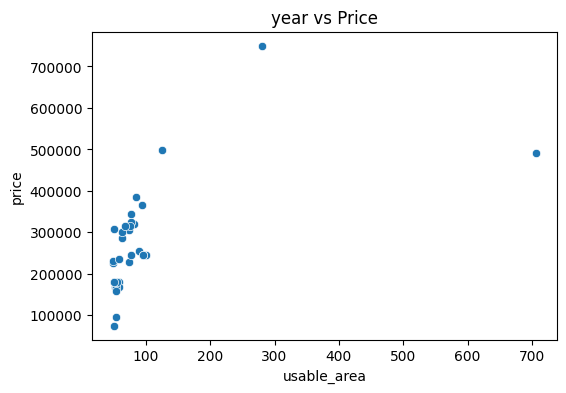

                                               url     price  \
211  https://www.idealista.com/inmueble/104990963/  750000.0   

                      zone                     neighborhood  built_area  \
211  otxarkoaga-txurdinaga  Otxarkoaga - Txurdinaga, Bilbao       301.0   

     usable_area  bedrooms  bathrooms  floor  exterior  ...  storage_room  \
211        280.0         5          4    5.0  exterior  ...          True   

     balcony    new    condition    year                   agency  \
211     True  False  Buen estado  1990.0  jose miguel ruiz garcia   

     consumption_label emissions_label  \
211                  E               E   

                                           description price_log  
211  API DIPUTACION, 4 HABITALE, VENDE MAGNIFICO DU...  13.52783  

[1 rows x 22 columns]


In [ ]:
print(dataCpy.loc[dataCpy["usable_area"]>=700])
#A house in otxarkoaga-txurdinaga, with 700m2 of usable are is cleary a leverage point, so we will delete it




data=dataCpy.loc[dataCpy["zone"]=="otxarkoaga-txurdinaga"]

plt.figure(figsize=(6,4))
sns.scatterplot(x=dataCpy["usable_area"], y='price', data=data)
plt.title(f"{col} vs Price")
plt.show()

print(dataCpy.loc[(dataCpy["price"] >= 700000) & (dataCpy["zone"] == "otxarkoaga-txurdinaga")])


In [ ]:
#Now we will fit two linear regression models, 1 with and another without the transofmation we made above, so that we can see how those transformation improved the model: 
#Comparar R2, MAE
#Compara heterosdacity